# Ablation Results Analysis

This notebook loads `ablation_logs/ablation_results.csv` and provides basic analysis of latency, accuracy, and cache hit rate across experimental conditions.


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

csv_path = "experiment_logs/ablation_results_regraded.csv"
df = pd.read_csv(csv_path)
df.head()

,timestamp,experiment,model,dataset_config,split,max_samples,shuffle_seed,chunk_source,prompt_template,similarity_threshold,...,preset,total_prompts,cache_hits,cache_hit_rate,avg_latency,avg_latency_hit,avg_latency_miss,answer_accuracy,wall_time,hit_breakdown
0,2025-12-15T02:11:30.501236,qwen-exact-only,Qwen/Qwen3-VL-2B-Instruct,val_balanced_instructions,val,1024,42,semantic,You are assisting with the GQA benchmark. Answ...,0.8,...,NaN,1024,80,0.078125,0.562084,0.000079,0.609712,0.331055,576.233244,"{""text:exact"": 80}"
1,2025-12-15T02:22:47.734778,qwen-semantic-0.5,Qwen/Qwen3-VL-2B-Instruct,val_balanced_instructions,val,1024,42,semantic,You are assisting with the GQA benchmark. Answ...,0.5,...,NaN,1024,993,0.969727,0.023758,0.002825,0.694265,0.334961,24.584492,"{""text"": 993}"
2,2025-12-15T02:23:54.610613,qwen-semantic-0.6,Qwen/Qwen3-VL-2B-Instruct,val_balanced_instructions,val,1024,42,semantic,You are assisting with the GQA benchmark. Answ...,0.6,...,NaN,1024,949,0.926758,0.055633,0.002741,0.724894,0.025391,57.479285,"{""text"": 949}"
3,2025-12-15T02:26:49.373205,qwen-semantic-0.7,Qwen/Qwen3-VL-2B-Instruct,val_balanced_instructions,val,1024,42,semantic,You are assisting with the GQA benchmark. Answ...,0.7,...,NaN,1024,805,0.786133,0.159040,0.002784,0.733407,0.049805,164.234418,"{""text"": 805}"
4,2025-12-15T02:32:40.314305,qwen-semantic-0.8,Qwen/Qwen3-VL-2B-Instruct,val_balanced_instructions,val,1024,42,semantic,You are assisting with the GQA benchmark. Answ...,0.8,...,NaN,1024,518,0.505859,0.330176,0.002773,0.665343,0.112305,341.166054,"{""text"": 518}"


## Basic info and summary

Inspect the columns and basic statistics for the key metrics.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   30 non-null     object 
 1   experiment                  30 non-null     object 
 2   model                       30 non-null     object 
 3   dataset_config              30 non-null     object 
 4   split                       30 non-null     object 
 5   max_samples                 30 non-null     int64  
 6   shuffle_seed                30 non-null     int64  
 7   chunk_source                30 non-null     object 
 8   prompt_template             30 non-null     object 
 9   similarity_threshold        30 non-null     float64
 10  embedding_layers            18 non-null     object 
 11  embedding_hook              30 non-null     object 
 12  max_cached_blocks           0 non-null      float64
 13  cache_dir                   30 non-nu

In [79]:
metrics = ["avg_latency", "answer_accuracy", "cache_hit_rate", "hit_accuracy", "miss_accuracy", "hit_latency", "miss_latency"]
df[metrics].describe()

KeyError: "['hit_accuracy', 'miss_accuracy', 'hit_latency', 'miss_latency'] not in index"

In [67]:
# Derive per-row hit/miss metrics using graded logsfrom pathlib import Pathimport csv# Latency per hit/miss is already in the summary CSVdf['hit_latency'] = df['avg_latency_hit']df['miss_latency'] = df['avg_latency_miss']# Derive hit/miss accuracy from graded per-sample logs (after regrade)graded_dir = Path('experiment_logs/ablation_logs_graded')graded_files = sorted(graded_dir.glob('*.csv'))hit_acc_list = []miss_acc_list = []def _safe_mean(vals):    vals = list(vals)    return sum(vals) / len(vals) if vals else float('nan')for i, _row in df.reset_index(drop=True).iterrows():    if i >= len(graded_files):        hit_acc_list.append(float('nan'))        miss_acc_list.append(float('nan'))        continue    log_path = graded_files[i]    with open(log_path, 'r', encoding='utf-8') as f:        reader = csv.DictReader(f)        hit_correct = []        miss_correct = []        for row in reader:            # After regrade, correctness is encoded as integer match_score (0/1)            match_score = int(row.get('match_score', 0))            is_correct_reg = bool(match_score)            cache_hit = row.get('cache_hit', 'False')            cache_hit = str(cache_hit).lower() == 'true'            if cache_hit:                hit_correct.append(1 if is_correct_reg else 0)            else:                miss_correct.append(1 if is_correct_reg else 0)    hit_acc_list.append(_safe_mean(hit_correct))    miss_acc_list.append(_safe_mean(miss_correct))df['hit_accuracy'] = hit_acc_listdf['miss_accuracy'] = miss_acc_list

## Define experimental condition

Here we define a compact `condition` label using a subset of columns. Adjust as needed based on how you structured the ablation (e.g., similarity thresholds, embedding layers, cache settings).

In [68]:
condition_cols = [
    "experiment",
    "similarity_threshold",
    "embedding_layers",
    "enable_semantic_text_cache",
    "enable_exact_text_cache",
]

for col in condition_cols:
    if col not in df.columns:
        print(f"Warning: column '{col}' not found in CSV; dropping from condition definition.")

condition_cols = [c for c in condition_cols if c in df.columns]

df["condition"] = (
    df[condition_cols]
    .astype(str)
    .agg(" | ".join, axis=1)
    if condition_cols
    else df["experiment"].astype(str)
)

df[["condition"] + metrics].head()

,condition,avg_latency,answer_accuracy,cache_hit_rate
0,qwen-exact-only | 0.8 | nan | False | True,0.562084,0.331055,0.078125
1,qwen-semantic-0.5 | 0.5 | nan | True | False,0.023758,0.334961,0.969727
2,qwen-semantic-0.6 | 0.6 | nan | True | False,0.055633,0.025391,0.926758
3,qwen-semantic-0.7 | 0.7 | nan | True | False,0.159040,0.049805,0.786133
4,qwen-semantic-0.8 | 0.8 | nan | True | False,0.330176,0.112305,0.505859


## Per-condition aggregates

Compute mean metrics per condition (useful if there are multiple runs per setting).

In [69]:
grouped = df.groupby("condition")[metrics].mean().reset_index()
grouped.sort_values("answer_accuracy", ascending=False)

,condition,avg_latency,answer_accuracy,cache_hit_rate
25,qwen-semantic-0.5 | 0.5 | nan | True | False,0.023758,0.334961,0.969727
24,qwen-exact-only | 0.8 | nan | False | True,0.562084,0.331055,0.078125
15,"qwen-embed-p0.7-v0.7 | 0.8 | prompt:384:0.7,vi...",0.120417,0.305664,0.821289
11,internvl-semantic-0.6 | 0.6 | nan | True | False,0.017796,0.303711,0.926758
10,internvl-semantic-0.5 | 0.5 | nan | True | False,0.009158,0.303711,0.969727
9,internvl-exact-only | 0.8 | nan | False | True,0.209980,0.298828,0.078125
1,internvl-embed-p0.7-v0.8 | 0.8 | prompt:384:0....,0.044698,0.289062,0.803711
23,"qwen-embed-p0.9-v0.9 | 0.8 | prompt:384:0.9,vi...",0.473209,0.252930,0.227539
0,internvl-embed-p0.7-v0.7 | 0.8 | prompt:384:0....,0.033178,0.236328,0.852539
21,"qwen-embed-p0.9-v0.7 | 0.8 | prompt:384:0.9,vi...",0.222973,0.232422,0.642578


## Plots: accuracy vs latency / hit rate

Scatter plots to visualize the trade-offs between latency, accuracy, and cache hit rate. Hover or annotate points by condition label when inspecting.

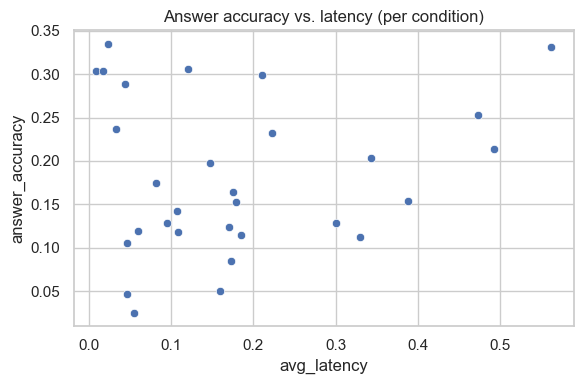

In [70]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=grouped,
    x="avg_latency",
    y="answer_accuracy",
)
plt.title("Answer accuracy vs. latency (per condition)")
plt.tight_layout()
plt.show()

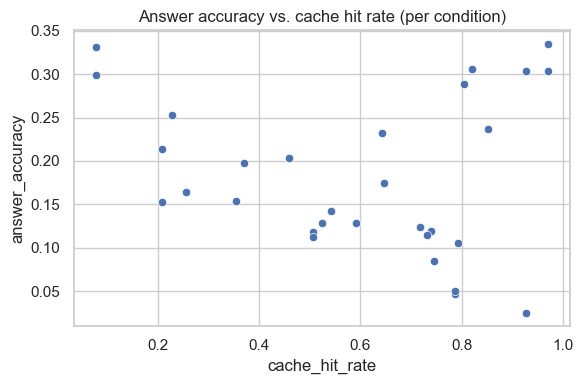

In [71]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=grouped,
    x="cache_hit_rate",
    y="answer_accuracy",
)
plt.title("Answer accuracy vs. cache hit rate (per condition)")
plt.tight_layout()
plt.show()

## Ranked table

Sort conditions by accuracy (and optionally latency) to see the best-performing configurations.

In [72]:
ranked = grouped.sort_values(["answer_accuracy", "avg_latency"], ascending=[False, True])
ranked.reset_index(drop=True).head(20)

,condition,avg_latency,answer_accuracy,cache_hit_rate
0,qwen-semantic-0.5 | 0.5 | nan | True | False,0.023758,0.334961,0.969727
1,qwen-exact-only | 0.8 | nan | False | True,0.562084,0.331055,0.078125
2,"qwen-embed-p0.7-v0.7 | 0.8 | prompt:384:0.7,vi...",0.120417,0.305664,0.821289
3,internvl-semantic-0.5 | 0.5 | nan | True | False,0.009158,0.303711,0.969727
4,internvl-semantic-0.6 | 0.6 | nan | True | False,0.017796,0.303711,0.926758
5,internvl-exact-only | 0.8 | nan | False | True,0.209980,0.298828,0.078125
6,internvl-embed-p0.7-v0.8 | 0.8 | prompt:384:0....,0.044698,0.289062,0.803711
7,"qwen-embed-p0.9-v0.9 | 0.8 | prompt:384:0.9,vi...",0.473209,0.252930,0.227539
8,internvl-embed-p0.7-v0.7 | 0.8 | prompt:384:0....,0.033178,0.236328,0.852539
9,"qwen-embed-p0.9-v0.7 | 0.8 | prompt:384:0.9,vi...",0.222973,0.232422,0.642578


## Per-model ablation analysis

Split results by underlying vision-language model and compute per-experiment metrics (each ablation row) for latency, accuracy, and cache hit rate.

In [73]:
# Aggregate metrics per model and experiment (each ablation setting)
per_model_metrics = metrics
per_model_exp = (
    df.groupby(["model", "experiment"])[per_model_metrics]
    .mean()
    .reset_index()
)

# Separate into the two backbone models for convenience
qwen_mask = per_model_exp["model"].str.contains("Qwen", case=False, na=False)
internvl_mask = per_model_exp["model"].str.contains("InternVL", case=False, na=False)

qwen_results = per_model_exp[qwen_mask].sort_values("experiment")
internvl_results = per_model_exp[internvl_mask].sort_values("experiment")

print("Qwen model ablation results (per experiment):")
display(qwen_results)

print("\nInternVL model ablation results (per experiment):")
display(internvl_results)


Qwen model ablation results (per experiment):


,model,experiment,avg_latency,answer_accuracy,cache_hit_rate
15,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.7-v0.7,0.120417,0.305664,0.821289
16,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.7-v0.8,0.173440,0.084961,0.745117
17,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.7-v0.9,0.184828,0.114258,0.732422
18,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.8-v0.7,0.169886,0.124023,0.718750
19,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.8-v0.8,0.300185,0.128906,0.523438
20,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.8-v0.9,0.343535,0.203125,0.459961
21,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.9-v0.7,0.222973,0.232422,0.642578
22,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.9-v0.8,0.387573,0.153320,0.353516
23,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.9-v0.9,0.473209,0.252930,0.227539
24,Qwen/Qwen3-VL-2B-Instruct,qwen-exact-only,0.562084,0.331055,0.078125



InternVL model ablation results (per experiment):


,model,experiment,avg_latency,answer_accuracy,cache_hit_rate
0,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.7-v0.7,0.033178,0.236328,0.852539
1,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.7-v0.8,0.044698,0.289062,0.803711
2,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.7-v0.9,0.046663,0.105469,0.792969
3,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.8-v0.7,0.059335,0.119141,0.740234
4,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.8-v0.8,0.094815,0.128906,0.590820
5,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.8-v0.9,0.107524,0.142578,0.542969
6,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.9-v0.7,0.081350,0.174805,0.647461
7,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.9-v0.8,0.147248,0.197266,0.370117
8,OpenGVLab/InternVL3_5-2B-Instruct,internvl-embed-p0.9-v0.9,0.175198,0.164062,0.254883
9,OpenGVLab/InternVL3_5-2B-Instruct,internvl-exact-only,0.209980,0.298828,0.078125


In [74]:
qwen_results

,model,experiment,avg_latency,answer_accuracy,cache_hit_rate
15,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.7-v0.7,0.120417,0.305664,0.821289
16,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.7-v0.8,0.173440,0.084961,0.745117
17,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.7-v0.9,0.184828,0.114258,0.732422
18,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.8-v0.7,0.169886,0.124023,0.718750
19,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.8-v0.8,0.300185,0.128906,0.523438
20,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.8-v0.9,0.343535,0.203125,0.459961
21,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.9-v0.7,0.222973,0.232422,0.642578
22,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.9-v0.8,0.387573,0.153320,0.353516
23,Qwen/Qwen3-VL-2B-Instruct,qwen-embed-p0.9-v0.9,0.473209,0.252930,0.227539
24,Qwen/Qwen3-VL-2B-Instruct,qwen-exact-only,0.562084,0.331055,0.078125


## Qwen semantic vs. embed ablations

Within the Qwen backbone, compare semantic cache thresholds (`qwen-semantic-x`) and embedding-based cache settings (`qwen-embed-x`) across latency, accuracy, and hit rate.

In [75]:
# Focus on Qwen experiments only
qwen_only = qwen_results.copy()
qwen_only["family"] = qwen_only["experiment"].map(
    lambda x: "semantic" if "semantic" in x
    else ("embed" if "embed" in x else "exact")
)

# Semantic family: parse similarity threshold from experiment name
qwen_semantic = qwen_only[qwen_only["family"] == "semantic"].copy()
qwen_semantic["semantic_thr"] = (
    qwen_semantic["experiment"]
    .str.extract(r"semantic-([0-9.]+)")[0]
    .astype(float)
)

# Embed family: parse prompt / vision thresholds from experiment name
qwen_embed = qwen_only[qwen_only["family"] == "embed"].copy()
qwen_embed[["prompt_thr", "vision_thr"]] = (
    qwen_embed["experiment"]
    .str.extract(r"p([0-9.]+)-v([0-9.]+)")
    .astype(float)
)

display(qwen_semantic[["experiment", "semantic_thr"] + metrics])
display(qwen_embed[["experiment", "prompt_thr", "vision_thr"] + metrics])

,experiment,semantic_thr,avg_latency,answer_accuracy,cache_hit_rate
25,qwen-semantic-0.5,0.5,0.023758,0.334961,0.969727
26,qwen-semantic-0.6,0.6,0.055633,0.025391,0.926758
27,qwen-semantic-0.7,0.7,0.159040,0.049805,0.786133
28,qwen-semantic-0.8,0.8,0.330176,0.112305,0.505859
29,qwen-semantic-0.9,0.9,0.492658,0.213867,0.208008


,experiment,prompt_thr,vision_thr,avg_latency,answer_accuracy,cache_hit_rate
15,qwen-embed-p0.7-v0.7,0.7,0.7,0.120417,0.305664,0.821289
16,qwen-embed-p0.7-v0.8,0.7,0.8,0.173440,0.084961,0.745117
17,qwen-embed-p0.7-v0.9,0.7,0.9,0.184828,0.114258,0.732422
18,qwen-embed-p0.8-v0.7,0.8,0.7,0.169886,0.124023,0.718750
19,qwen-embed-p0.8-v0.8,0.8,0.8,0.300185,0.128906,0.523438
20,qwen-embed-p0.8-v0.9,0.8,0.9,0.343535,0.203125,0.459961
21,qwen-embed-p0.9-v0.7,0.9,0.7,0.222973,0.232422,0.642578
22,qwen-embed-p0.9-v0.8,0.9,0.8,0.387573,0.153320,0.353516
23,qwen-embed-p0.9-v0.9,0.9,0.9,0.473209,0.252930,0.227539


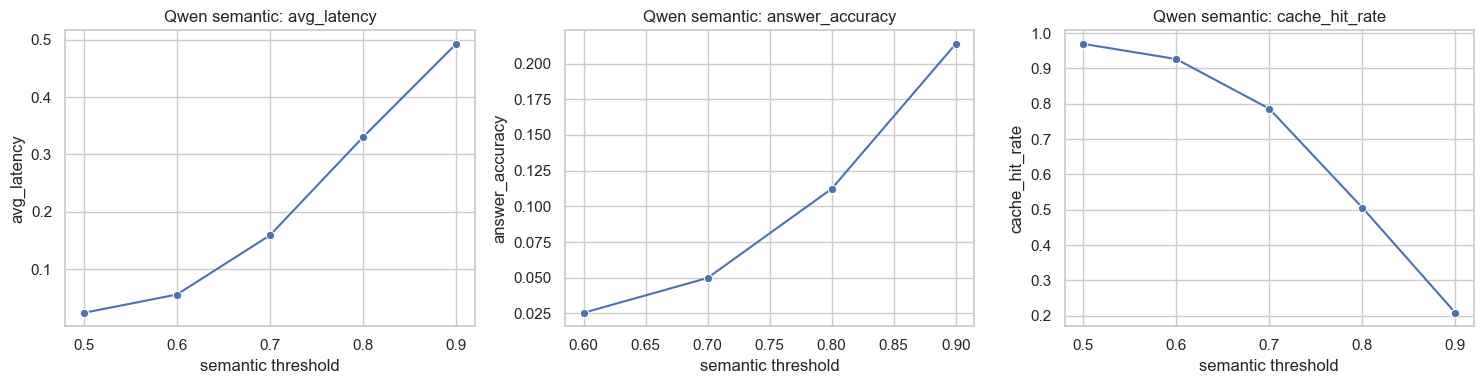

In [84]:
# Line plots for Qwen semantic ablations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, metric in zip(axes, metrics):
    if metric == "answer_accuracy":
        sns.lineplot(
            data=qwen_semantic.sort_values("semantic_thr")[1:],
            x="semantic_thr",
            y=metric,
            marker="o",
            ax=ax,
        )
    else:
        sns.lineplot(
            data=qwen_semantic.sort_values("semantic_thr"),
            x="semantic_thr",
            y=metric,
            marker="o",
            ax=ax,
        )
    ax.set_title(f"Qwen semantic: {metric}")
    ax.set_xlabel("semantic threshold")
plt.tight_layout()
plt.savefig("threshold.svg")

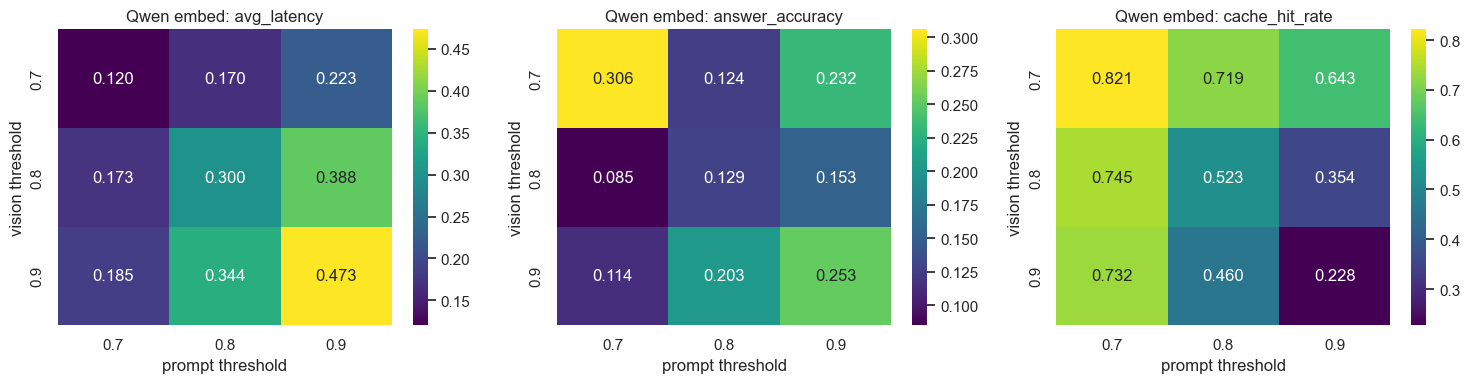

In [82]:
# Heatmaps for Qwen embed ablations (prompt vs vision threshold)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, metric in zip(axes, metrics):
    pivot = qwen_embed.pivot(index="vision_thr", columns="prompt_thr", values=metric)
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", ax=ax)
    ax.set_title(f"Qwen embed: {metric}")
    ax.set_xlabel("prompt threshold")
    ax.set_ylabel("vision threshold")
plt.tight_layout()
plt.savefig("threshold2.svg")

## Summary table for paper

Export a concise table of per-model, per-experiment metrics for latency, accuracy, and hit rate that can be copied into the paper.

In [78]:
summary_cols = ["model", "experiment"] + per_model_metrics
summary = per_model_exp[summary_cols].copy()
summary[per_model_metrics] = summary[per_model_metrics].round(4)

print("Per-model, per-experiment summary (TSV format for easy copy/paste):")
print(summary.to_csv(sep="\t", index=False))

Per-model, per-experiment summary (TSV format for easy copy/paste):
model	experiment	avg_latency	answer_accuracy	cache_hit_rate
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.7-v0.7	0.0332	0.2363	0.8525
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.7-v0.8	0.0447	0.2891	0.8037
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.7-v0.9	0.0467	0.1055	0.793
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.8-v0.7	0.0593	0.1191	0.7402
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.8-v0.8	0.0948	0.1289	0.5908
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.8-v0.9	0.1075	0.1426	0.543
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.9-v0.7	0.0814	0.1748	0.6475
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.9-v0.8	0.1472	0.1973	0.3701
OpenGVLab/InternVL3_5-2B-Instruct	internvl-embed-p0.9-v0.9	0.1752	0.1641	0.2549
OpenGVLab/InternVL3_5-2B-Instruct	internvl-exact-only	0.21	0.2988	0.0781
OpenGVLab/InternVL3_5-2B-Instruct	internvl-semantic-0.5	0.0092	0.3037	0.9697
Open